## Reproduction ratio correction

Imports

In [85]:
import numpy as np
import pandas as pd
import scipy.linalg
import epyestim.covid19 as covid19
from epyestim import bagging_r
import matplotlib.pyplot as plt

## Read data

In [49]:
# Colocation data
colocation_matrix=pd.read_csv('Matrix_Example',index_col=0)     

# Populations of departments
departments_population=pd.read_csv('Populations_Example',index_col=0)
departments_population=pd.Series(departments_population.iloc[:,0])

# New infections in departments
new_infections_departments = pd.read_csv('Cases_Example', index_col=0)

N = departments_population.shape[0]

## Compute the reproduction operator and $v^*$, then obtain corrected incidence  

In [98]:
# Obtain reproduction operator
R = colocation_matrix.mul(departments_population,axis=0)

# Compute left eigenvector
w,vl,vr=scipy.linalg.eig(R.to_numpy(),left=True)
v_star=vl[:,w.argmax()]/np.sum(vl[:,w.argmax()])
v_star=pd.Series(v_star)
v_star.set_axis(R.columns,inplace=True)

# Compute new infections globally
new_infections = new_infections_departments.copy()
new_infections['total'] = new_infections.iloc[:,1:].sum(axis=1) 
new_infections['date']=pd.to_datetime(new_infections['date'])
new_infections = new_infections.set_index('date')['total']

# Compute new infections corrected, i.e., weighted by v_star)
new_infections_corr = new_infections_departments.copy()
new_infections_corr.iloc[:,1:]=new_infections_corr.iloc[:,1:].mul(v_star*N,axis=1)
new_infections_corr['total'] = new_infections_corr.iloc[:,1:].sum(axis=1) 
new_infections_corr['date']=pd.to_datetime(new_infections_corr['date'])
new_infections_corr=new_infections_corr.set_index('date')['total']

#display
display(new_infections.head())
display(new_infections_corr.head())

## EpiEstim

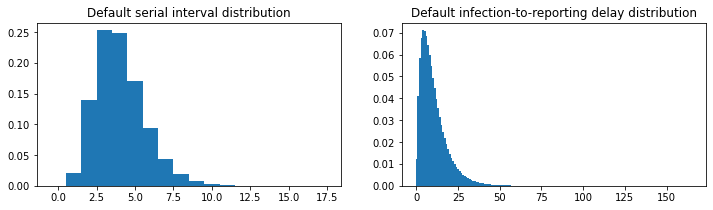

In [89]:
si_distrb = covid19.generate_standard_si_distribution()
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()

fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].bar(range(len(si_distrb)), si_distrb, width=1)
axs[1].bar(range(len(delay_distrb)), delay_distrb, width=1)
axs[0].set_title('Default serial interval distribution')
axs[1].set_title('Default infection-to-reporting delay distribution')
plt.show()

In [106]:
estimated_R = bagging_r( confirmed_cases=new_infections, gt_distribution=si_distrb, delay_distribution=delay_distrb, smoothing_window=7, r_window_size=7, a_prior=4.3, b_prior=1.0)
estimated_R_corr = bagging_r( confirmed_cases=new_infections_corr, gt_distribution=si_distrb, delay_distribution=delay_distrb, smoothing_window=7, r_window_size=7, a_prior=4.3, b_prior=1.0)
display(estimated_R.head())
display(estimated_R_corr.head())

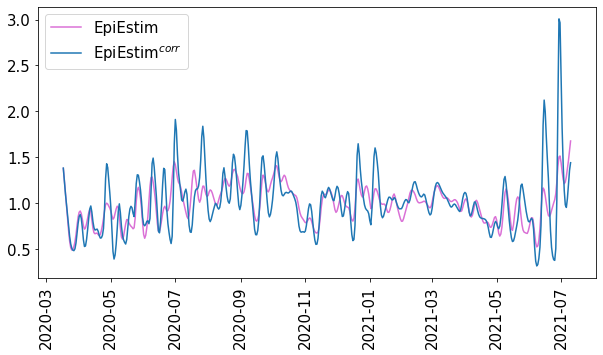

In [114]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(estimated_R.index[7:],estimated_R['R_mean'][7:],color='orchid',label='EpiEstim')
ax.plot(estimated_R_corr.index[7:],estimated_R_corr['R_mean'][7:],color='tab:blue',label=r'EpiEstim$^{corr}$')
ax.tick_params(axis='x',labelsize=15,rotation=90)
ax.tick_params(axis='y',labelsize=15)
_=ax.legend(fontsize=15)